# Premissa do projeto

## Neste trabalho, irei prever o preço de carros com base em diversas características. Nosso conjunto de dados são anúncios de carros que contém informações como: Características do carro, características do anúncio, data de criação do anúncio etc. Utilizarei um modelo de Random Forest para fazer as previsões. A ideia é que nosso modelo possa prever o preço dos carros com um valor que esteja próximo do que nós possuímos em nossos dados históricos, assim podemos ter parâmetro de um cenário real para comparar as previsões do modelo.

# Bibliotecas Utilizadas

In [80]:
!pip install -q sweetviz

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import sweetviz as sv

np.random.seed(14)

In [82]:
df = pd.read_csv('/content/autos.csv', encoding = "ISO-8859-1", low_memory=False)

In [83]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [84]:
df.shape

(371528, 20)

# Breve análise dos dados

## Descrição das variáveis


*   dateCrawled - Data em que os dados foram coletados

*   name - Nome do carro

*   seller - Tipo de vendedor

*   offerType - Tipo de oferta

*   Price - Preço do carro (EM EURO)

*   abtest - Se o veículo sofreu um tipo de teste AB
*   vehicleType - Tipo do veículo


*   yearOfRegistration - Ano de registro do carro

*   gearbox - Se o carro é manual ou automático


*   powerPS - Potência do carro.


*   model - Modelo do carro


*   Kilometer - Quilometragem do carro


*   monthOfRegistration - Mês em que o carro foi registrado

*   fuelType - Tipo de combustível: Elétrico, gasolina etc.

*   brand - Marca do carro

*   notRepairedDamage - Se o carro já sofreu algum tipo de reparo

*   dateCreated - Data em que o anúncio do carro foi criado

*   nrOfPictures - Número de fotos do carro no anúncio

*   postalCode - Código postal (CEP)

*   lastSeen - Última visualização do anúncio do carro



In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

In [86]:
# Filtrar apenas colunas do tipo object
df_obj = df.select_dtypes(include=['object'])

# Transformar o DataFrame de forma que todas as colunas sejam 'derretidas' em duas colunas
df_melted = df_obj.melt()

# Contar os valores de cada coluna original
value_counts = df_melted.groupby('variable')['value'].value_counts()

In [87]:
len(value_counts.value_counts())

455

*   Em nosso conjunto de dados, há muitas variáveis categóricas e muita variabilidade entre cada categoria. Precisamos tratar isso reduzindo ao máximo a quantidade de variações nas categorias, para que possamos diminuir a variabildiade e nosso modelo possa aprender melhor, pois quanto mais dimensões tivermos, mais complexo será para o modelo aprender
* No momento, temos 455 tipos de informações diferentes entre todas as colunas categóricas da nossa base de dados. O que significa que, se transformarmos essas variáveis futuramente para que o modelo possa compreender, teremos 455 dimensões a mais em nosso conjunto de dados, isso torna a aprendizagem do nosso modelo extremamente complexa

count    3.715280e+05
mean     1.729514e+04
std      3.587954e+06
min      0.000000e+00
25%      1.150000e+03
50%      2.950000e+03
75%      7.200000e+03
max      2.147484e+09
Name: price, dtype: float64


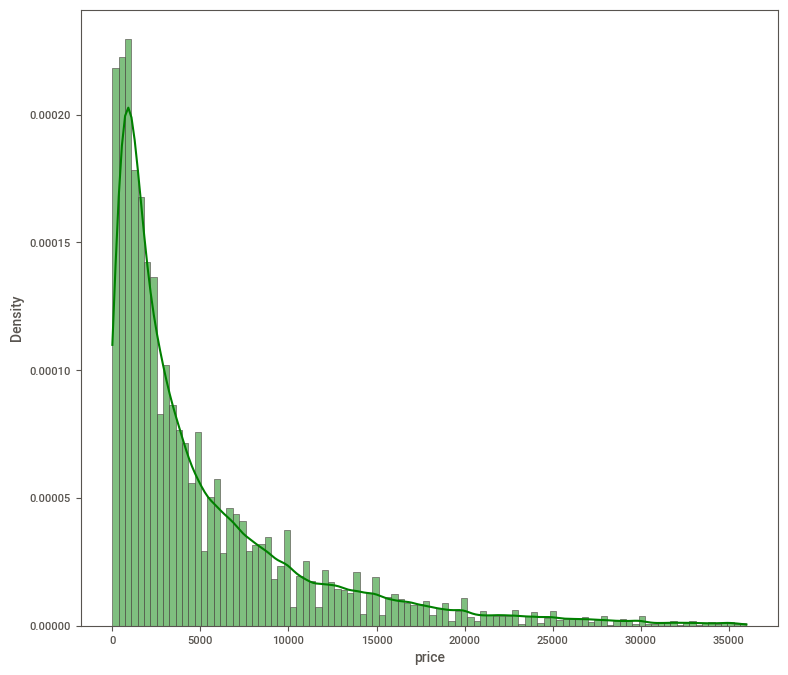

In [88]:
print(df['price'].describe())

# Removendo outliers com base no limiar do percetil 0.99 para termos uma visualização da distribuição dos dados
df_cleaned = df[df['price'] < df['price'].quantile(0.99)]

plt.figure(figsize=(9, 8))
sns.histplot(df_cleaned['price'], color='g', bins=100, kde=True, stat="density")
plt.show()

* A distribuição dos dados de nossa variável alvo "Price" não segue uma distribuição normal. Temos uma concentração muito maior de carros que possuem valores inferiores a 5000. Devemos tomar o cuidado para que isso não afete a aprendizagem do modelo e crie um viés, tornando o modelo muito bom em predizer o valor de carros com valores baixos, mas incapacitado de trazer boas previsões para carros com valores mais altos

# Pré processamento

## Após essa breve análise, podemos averiguar que nosso conjunto de dados precisará de um tratamento robusto. Antes de entrarmos em análises mais aprofundadas de nosso conjunto de dados, faremos:
  * Tratamento em dados faltantes
  * Tratamento de outliers
  * Normalização para diminuir a disparidade dos valores
  * Diminuição da dimensionalidade nos dados categóricos
  * Feature Engineering

### Tratando os dados faltantes

In [89]:
# Exibir a soma de valores nulos para cada coluna
null_counts = df.isnull().sum()

# Verificar se há valores nulos e imprimir se houver
if null_counts.sum() != 0:
    print(null_counts[null_counts != 0])
    valores_nulos = null_counts[null_counts != 0].index.tolist()

vehicleType          37869
gearbox              20209
model                20484
fuelType             33386
notRepairedDamage    72060
dtype: int64


In [90]:
for coluna_nula in valores_nulos:
  col_mode = df[coluna_nula].mode()[0]
  df[coluna_nula].fillna(col_mode, inplace = True)

<ipython-input-90-a4f67356bc9f>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[coluna_nula].fillna(col_mode, inplace = True)


* Temos somente dados nulos em colunas categóricas, então utilizarei a moda para tratar os valores nulos, pois como vimos anteriormente, nossos dados não seguem uma distribuição normal, então estou apenas inflando o ponto mais alto da distribuição dos dados, o que não interferirá na distribuição total

In [91]:
df.drop_duplicates(inplace=True)

* Dropando dados totalmente duplicados

### Tratamento de Outliers

#### Neste trecho, tratarei somente os outliers da nossa variável alvo "Price", pois um modelo de combinações de árvore, por sua robustez, não vale o custo benefício entre Tempo X Ganho de performance, pois o ganho será tão ínfimo que não é interessante o tempo que gastaríamos tratando cada variável independente

                                             |          | [  0%]   00:00 -> (? left)


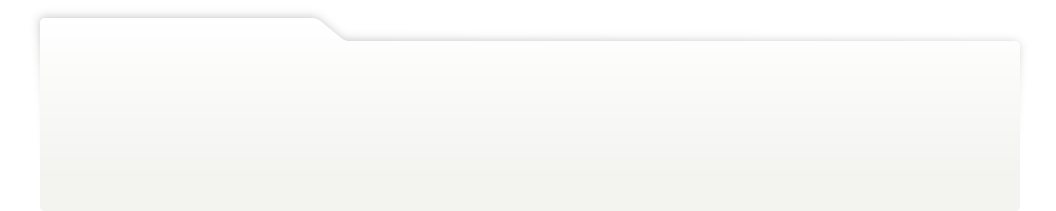
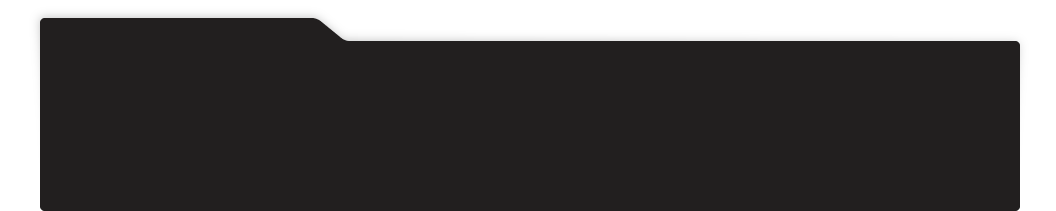
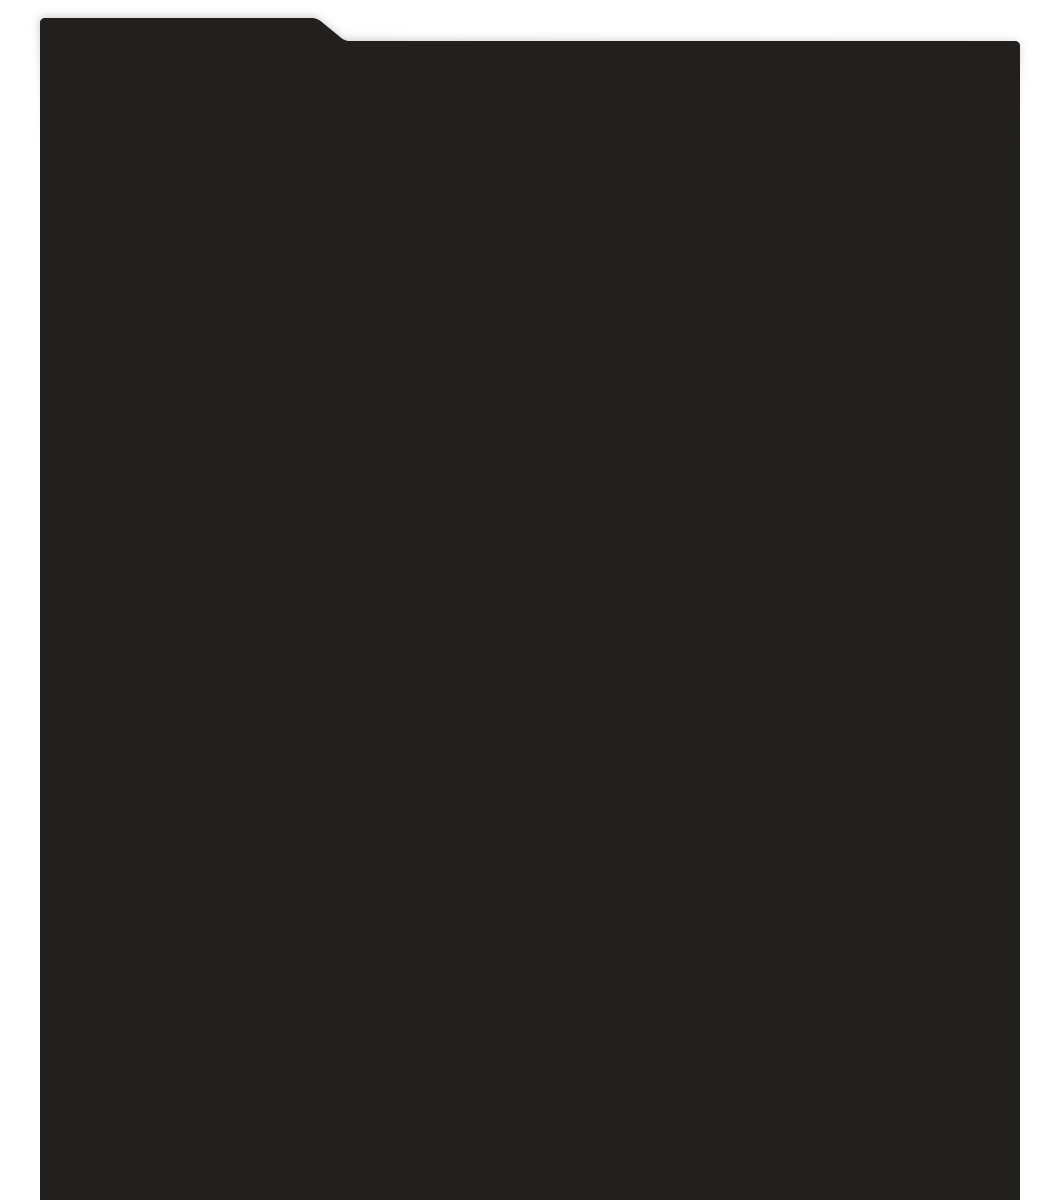
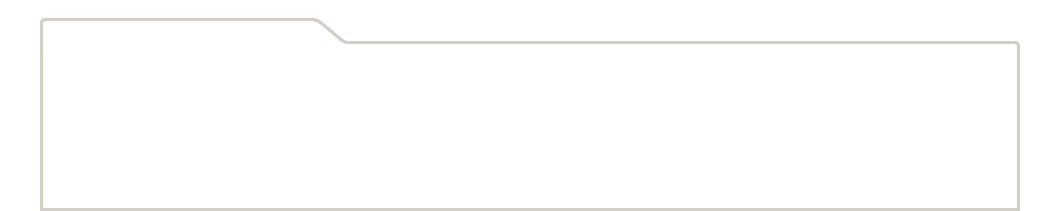
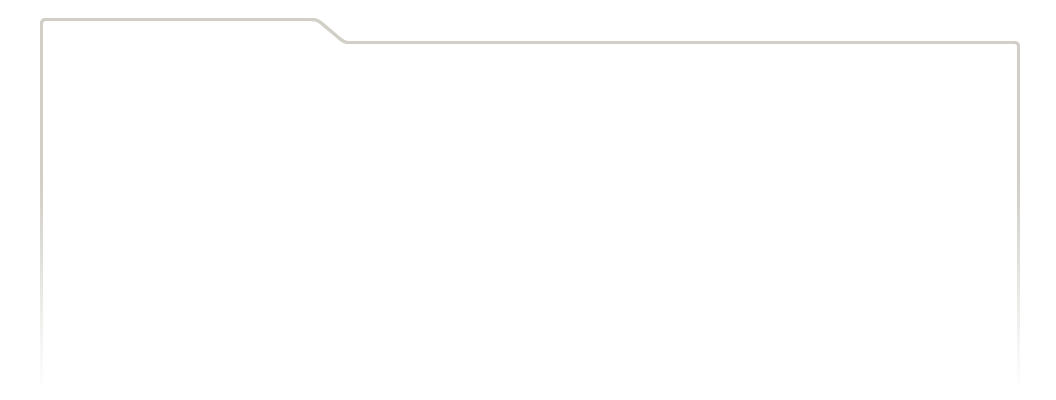
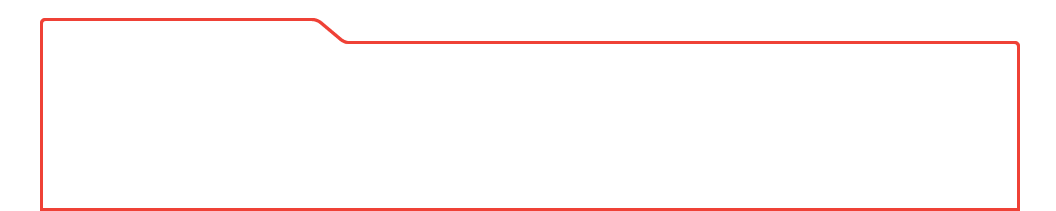
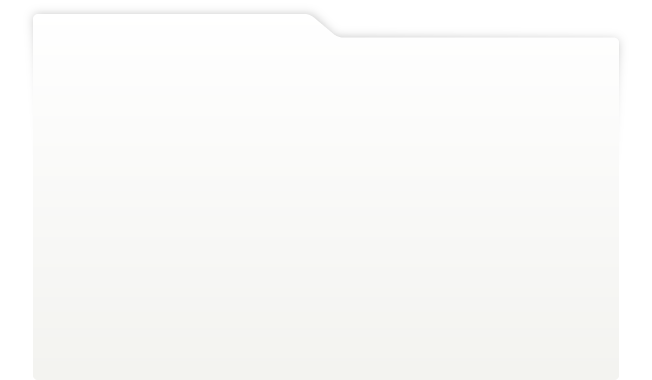
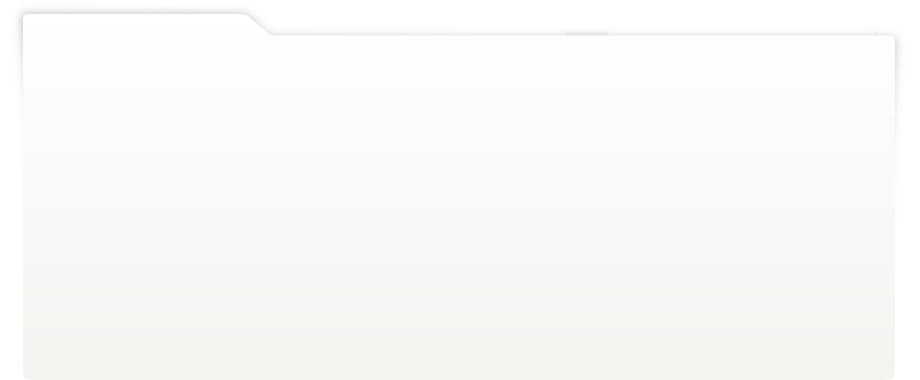
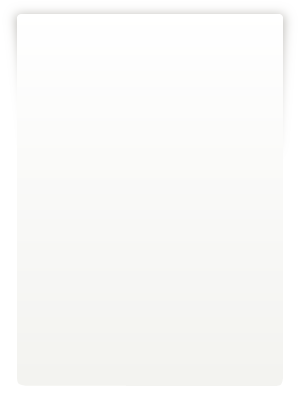
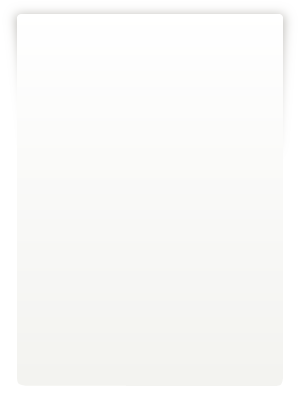
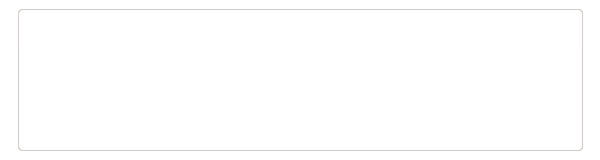
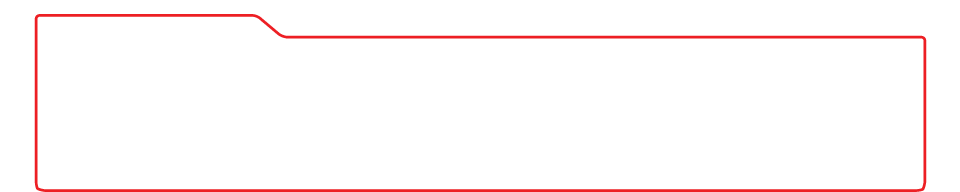
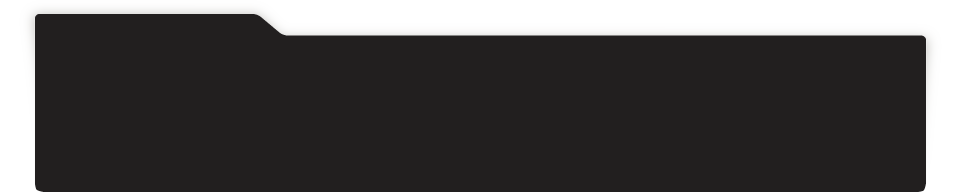
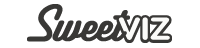
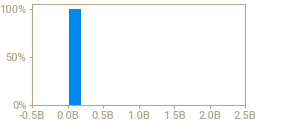
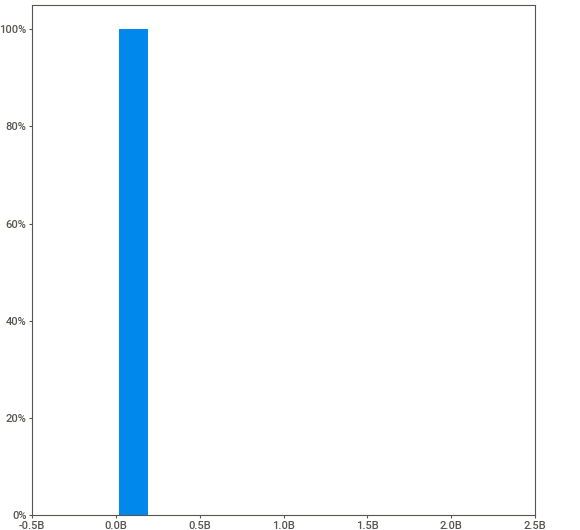
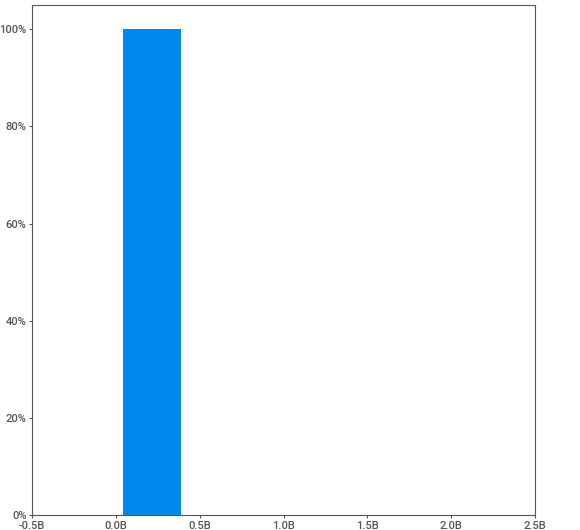
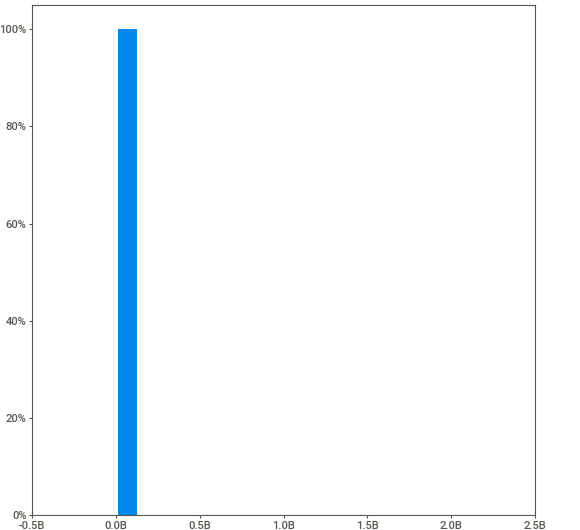
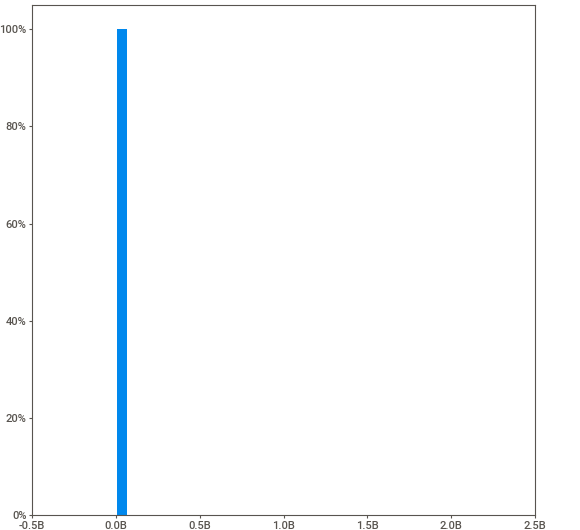
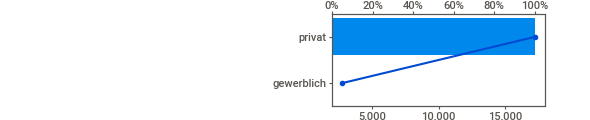
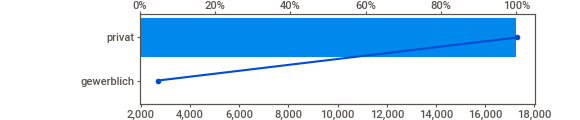
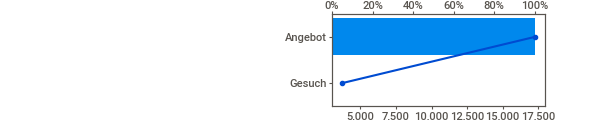
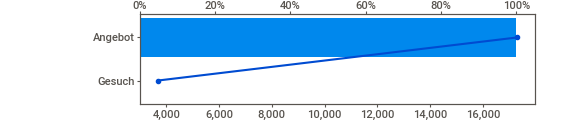
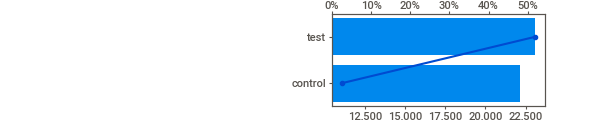
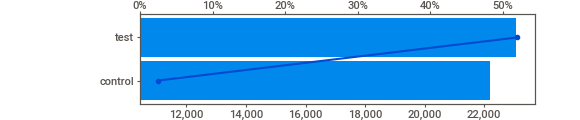
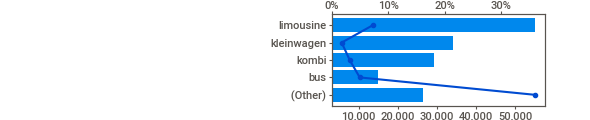
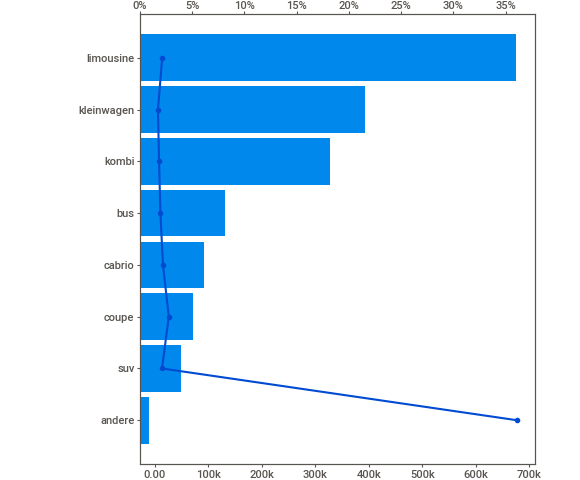
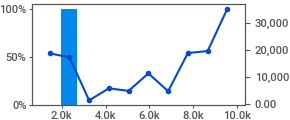
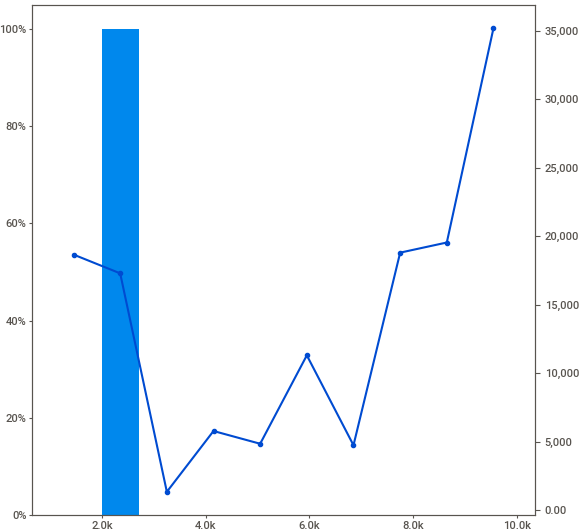
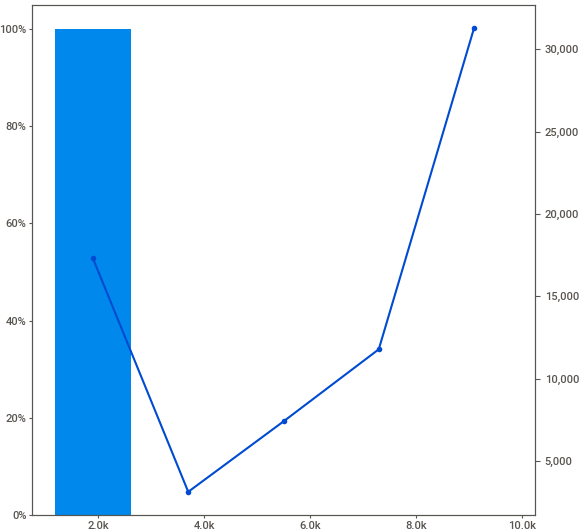
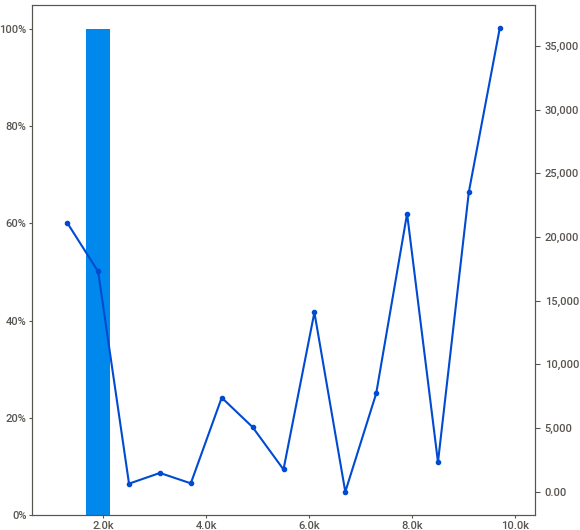
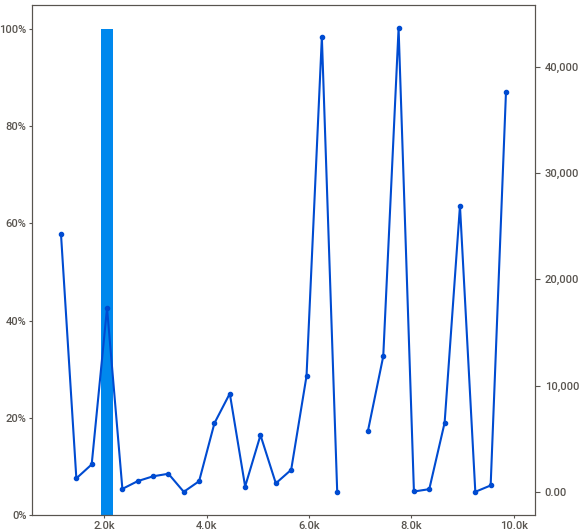
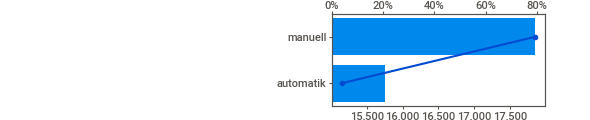
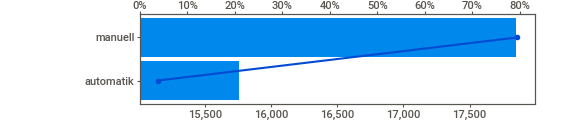
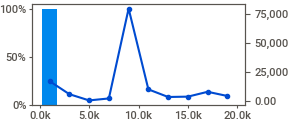
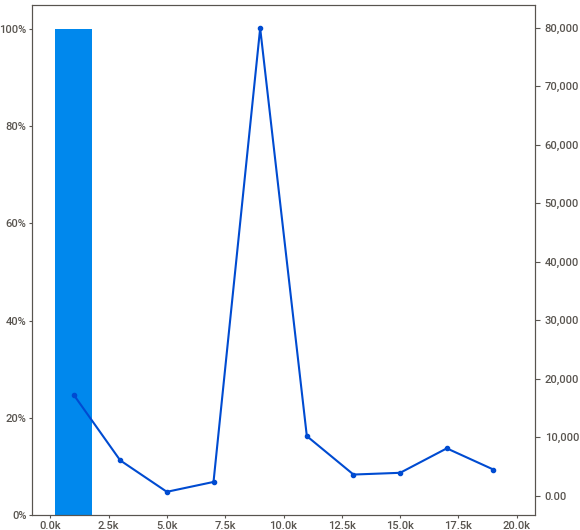
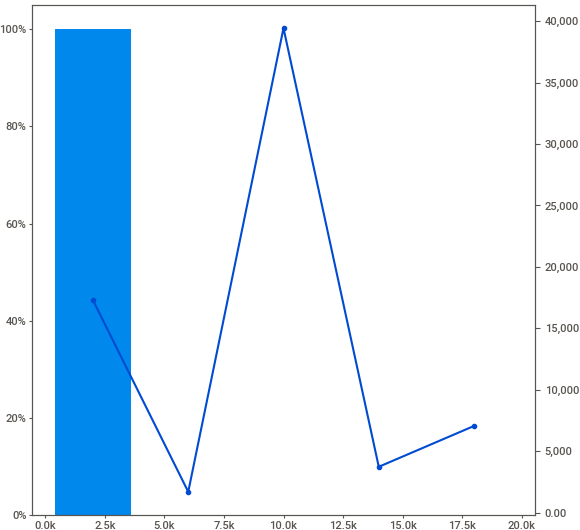
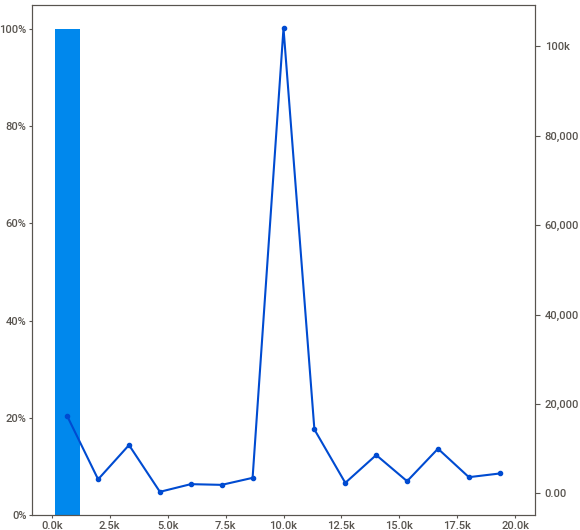
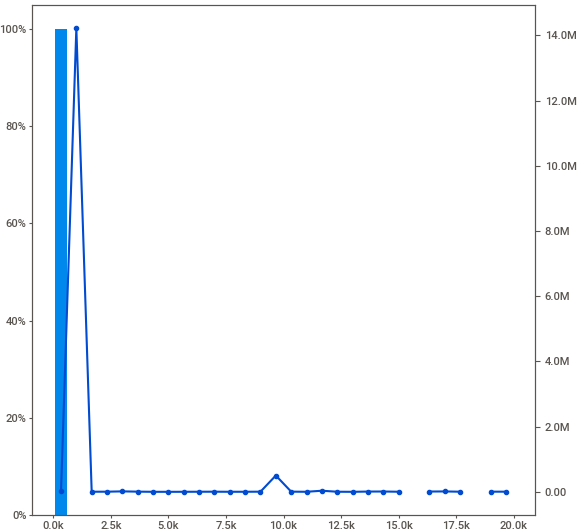
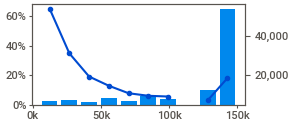
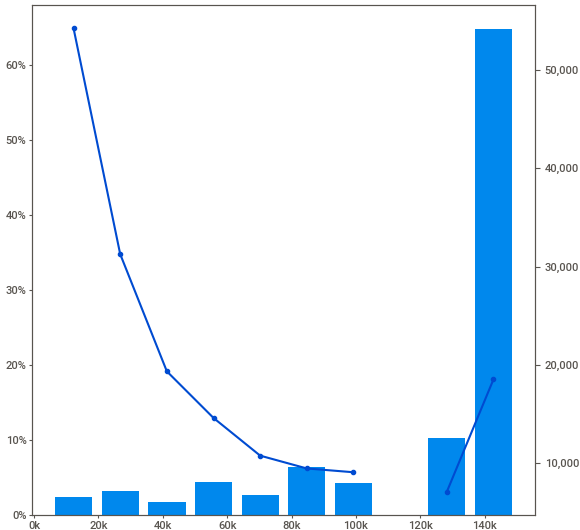
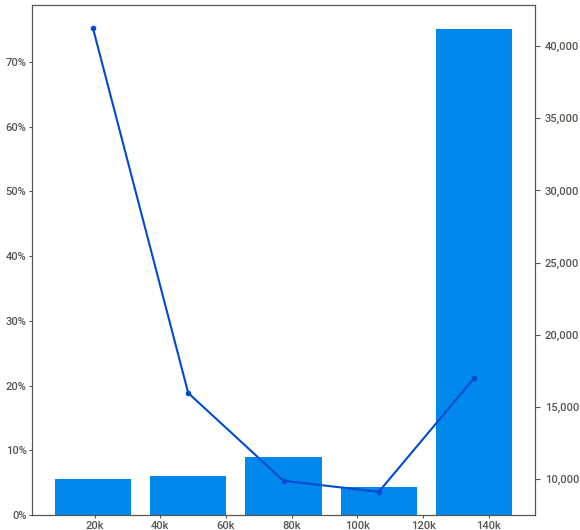
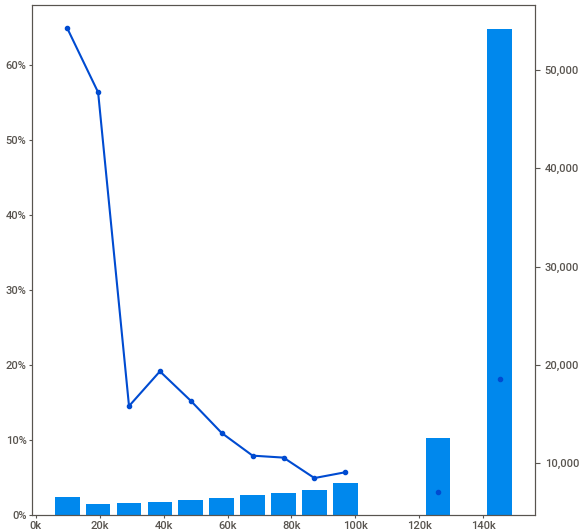
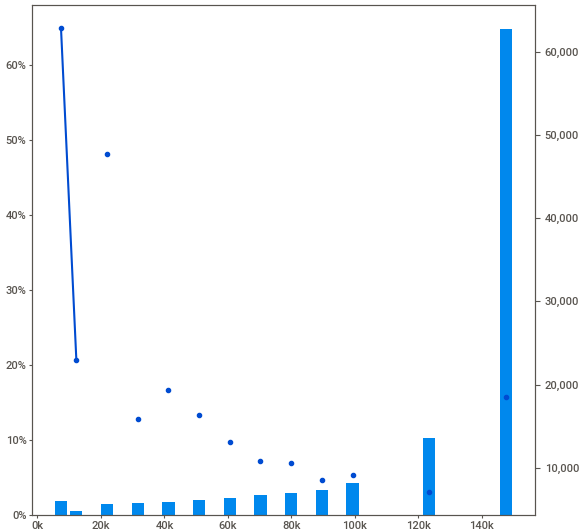
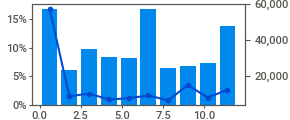
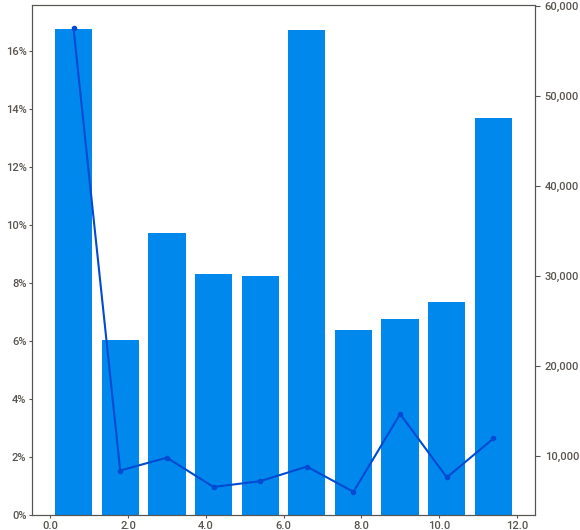
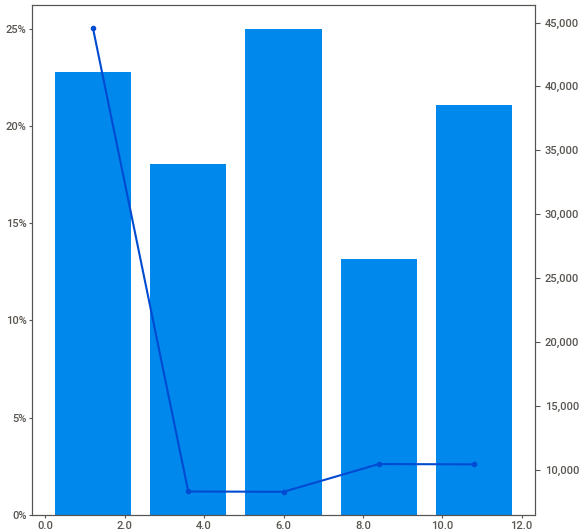
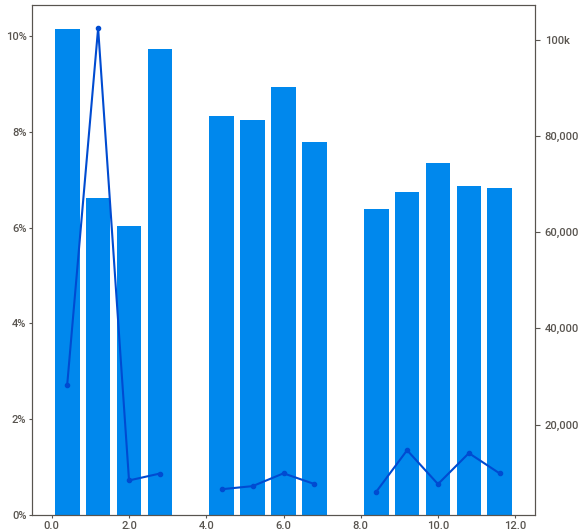
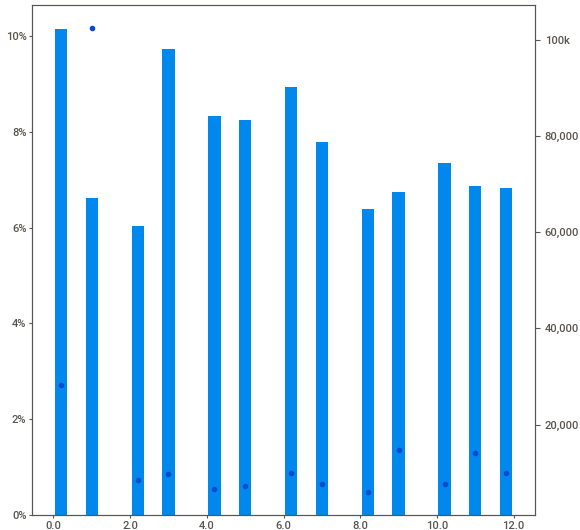
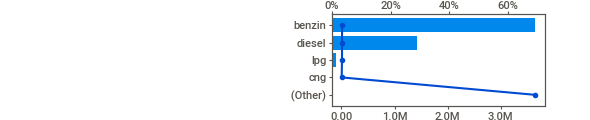
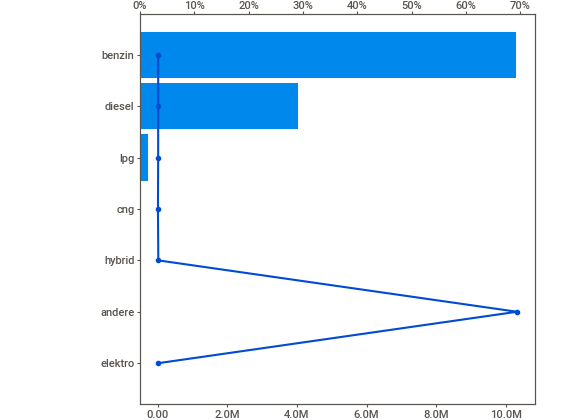
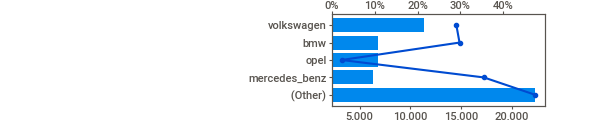
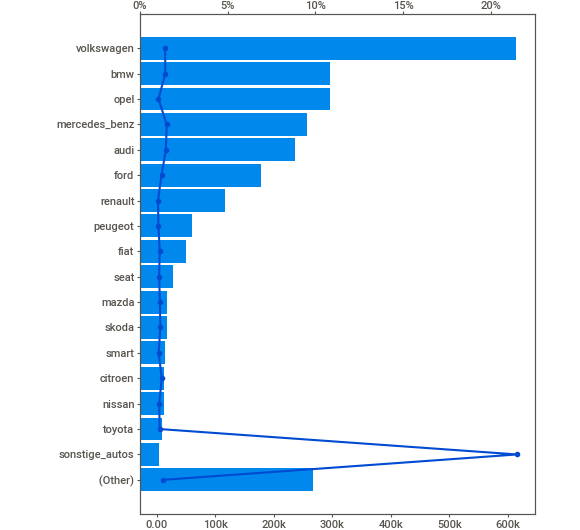
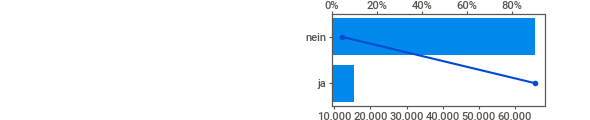
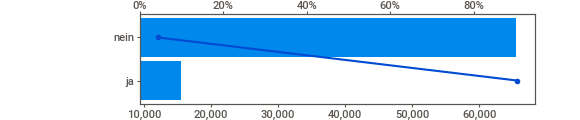
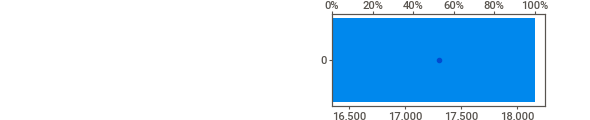
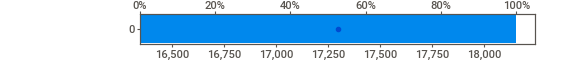
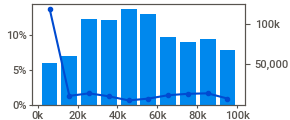
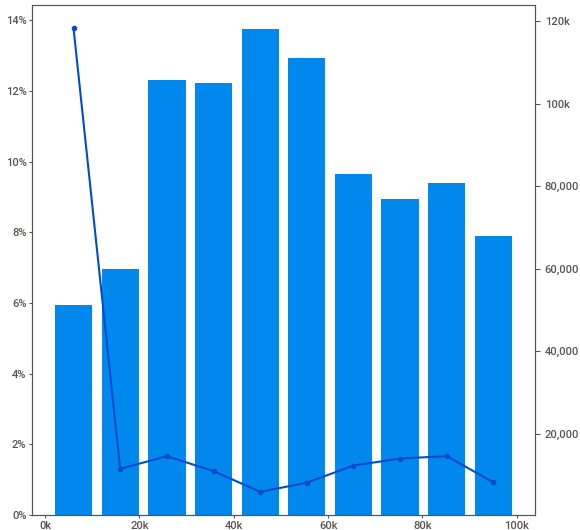
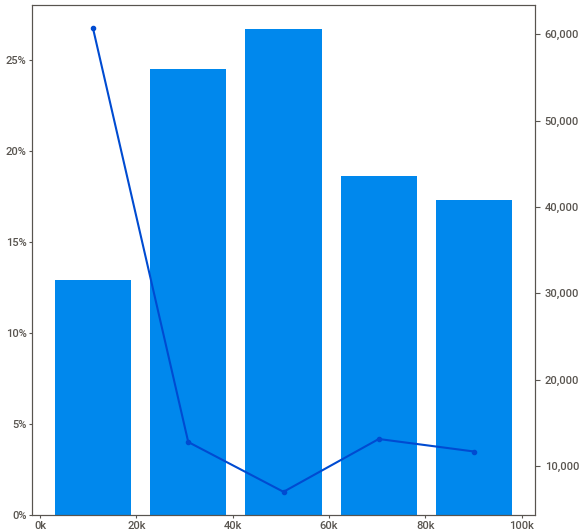
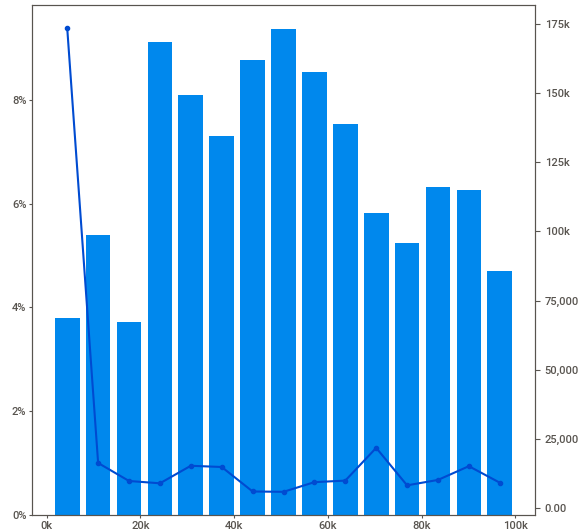
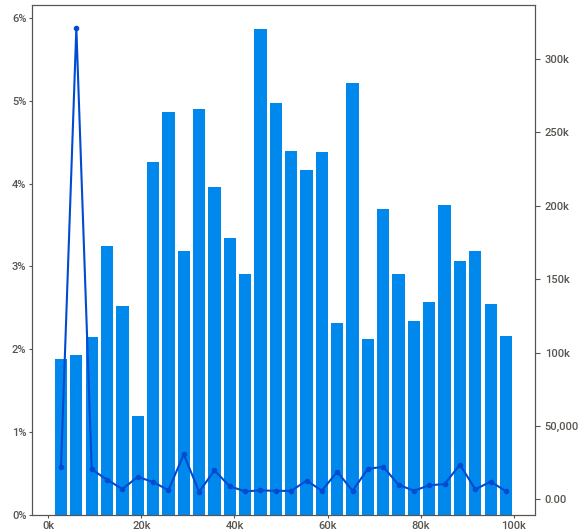
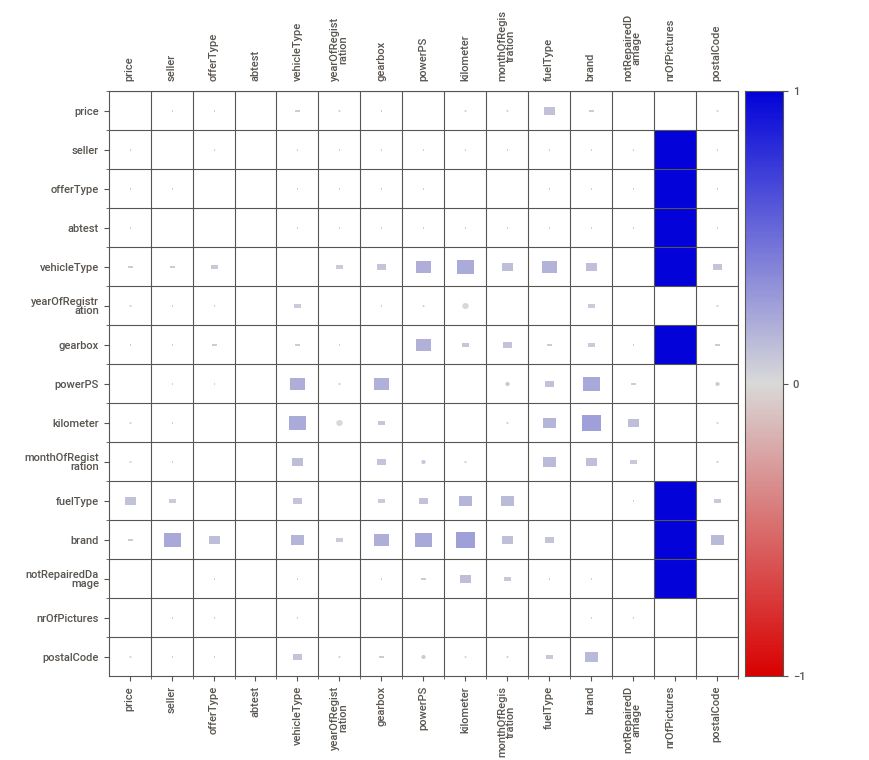
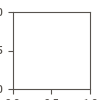

In [92]:
eda = sv.analyze(source = df, target_feat = 'price')
eda.show_notebook()

<Axes: title={'center': 'Distribuição dos preços dos carros'}>

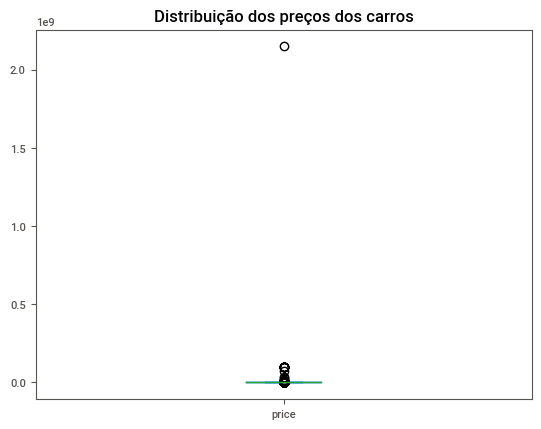

In [93]:
df['price'].plot(kind='box', title='Distribuição dos preços dos carros')

* Há valores extremamente discrepantes, fazendo com que nosso gráfico sequer apareça. Iremos tratar esses dados

In [94]:
# Calculando o percentil 0.99 para a coluna 'price'
percentil_99 = df['price'].quantile(0.99)

# Substituindo os valores maiores que 350.000 pelo valor do percentil 0.99
df['price'] = df['price'].apply(lambda x: percentil_99 if x > 300000 else x)
df['price'] = df['price'].apply(lambda x: 100 if x < 100 else x)

# Verificando se a substituição foi feita corretamente
print(df['price'].describe())

count    371524.000000
mean       5734.468304
std        8681.948437
min         100.000000
25%        1150.000000
50%        2950.000000
75%        7200.000000
max      300000.000000
Name: price, dtype: float64


* Ao analisar o gráfico no SweetViz e o gráfico da célula [29], defini um limiar de valor mínimo e valor máximo em que os preços dos meus carros podem alcançar. Dificlmente terei um carro maior que €300k e menor que €100, então tratei os outliers trazendo eles para um limiar mínimo de €100 e um limiar máximo de €300k

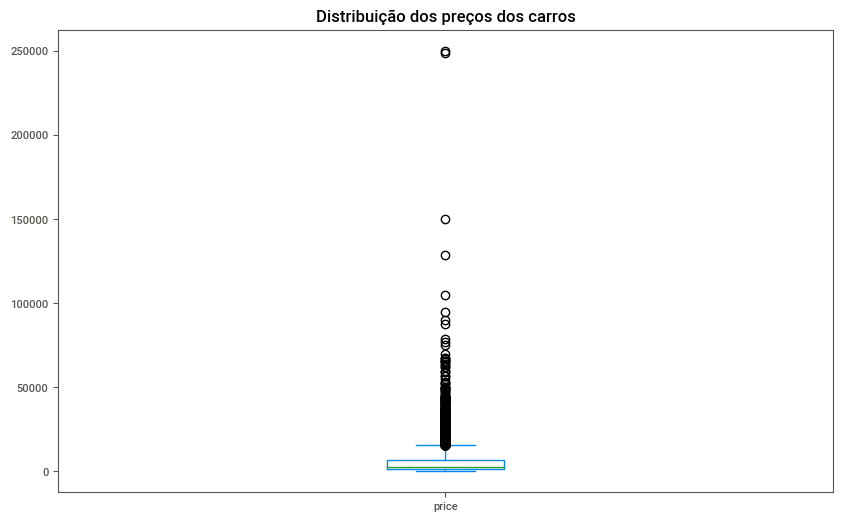

In [95]:
plt.figure(figsize=(10, 6))
df_sampled = df.sample(n=10000, random_state=14)
df_sampled['price'].plot(kind='box', title='Distribuição dos preços dos carros')
plt.show()

### Feature Engineering

#### Neste trecho, iremos diminuir a dimensionalidade das variáveis categóricas, agrupando informações e criando novas variáveis. Além disso, irei excluir colunas que não fizerem sentido pro nosso modelo

In [96]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480.0,test,limousine,1993,manuell,0,golf,150000,0,benzin,volkswagen,nein,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300.0,test,coupe,2011,manuell,190,golf,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800.0,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,nein,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500.0,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600.0,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [97]:
# Buscando a quantidade de variações dessa coluna
df.nrOfPictures.value_counts()

,count
nrOfPictures,
0,371524


In [98]:
# Verificando a quantidade total de variações de nomes
len(df.name.value_counts())

233531

In [99]:
# Verificando quantas variações nós temos
df.vehicleType.value_counts()

,count
vehicleType,
limousine,133763
kleinwagen,80022
kombi,67563
bus,30201
cabrio,22898
coupe,19013
suv,14707
andere,3357


In [100]:
# Encontrar as 3 categorias mais comuns
top_3_vehicle_types = df['vehicleType'].value_counts().nlargest(3).index

# Substituir todas as outras categorias por "outros"
df.loc[~df['vehicleType'].isin(top_3_vehicle_types), 'vehicleType'] = 'outros'

# Verificando o resultado
print(df['vehicleType'].value_counts())

vehicleType
limousine     133763
outros         90176
kleinwagen     80022
kombi          67563
Name: count, dtype: int64


In [101]:
# Verificando se a coluna está como INT
df.yearOfRegistration.dtype

dtype('int64')

In [102]:
# Verificando quantas variações nós temos
df.model.value_counts()

,count
model,
golf,50554
andere,26399
3er,20567
polo,13092
corsa,12573
...,...
serie_2,8
rangerover,6
serie_3,4


In [103]:
# Encontrar as 3 categorias mais comuns
top_3_models = df['model'].value_counts().nlargest(3).index

# Substituir todas as outras categorias por "outros"
df.loc[~df['model'].isin(top_3_models), 'model'] = 'outros'

# Verificando o resultado
print(df['model'].value_counts())

model
outros    274004
golf       50554
andere     26399
3er        20567
Name: count, dtype: int64


In [104]:
df.drop(['dateCrawled', 'postalCode', 'nrOfPictures', 'name'], axis=1, inplace=True)

* dateCrawled é a data em que esses dados foram coletados, para nossa análise essa informação não será relevante, então dropei essa coluna
* Não trabalharemos com geolocalização, então não fará sentido utilizarmos o código postal, então dropei essa coluna
* O número de pictures só há 1 único valor "0" para todas as linhas, então também droparei essa coluna, pois quanto menos dimensões tivermos, mais fácil para o modelo compreender o conjunto de dados
* Não é interessante trabalhar com o nome do veículo, pois há muitas variações e não agregará nenhuma informação relevante no aprendizado do nosso modelo, então dropei essa coluna

In [105]:
# Verificando quantas variações nós temos
df.monthOfRegistration.value_counts()

,count
monthOfRegistration,
0,37675
3,36170
6,33166
4,30918
5,30631
7,28956
10,27337
11,25489
12,25380


* Não existe mês 0, o que é um erro, então teremos de tratar

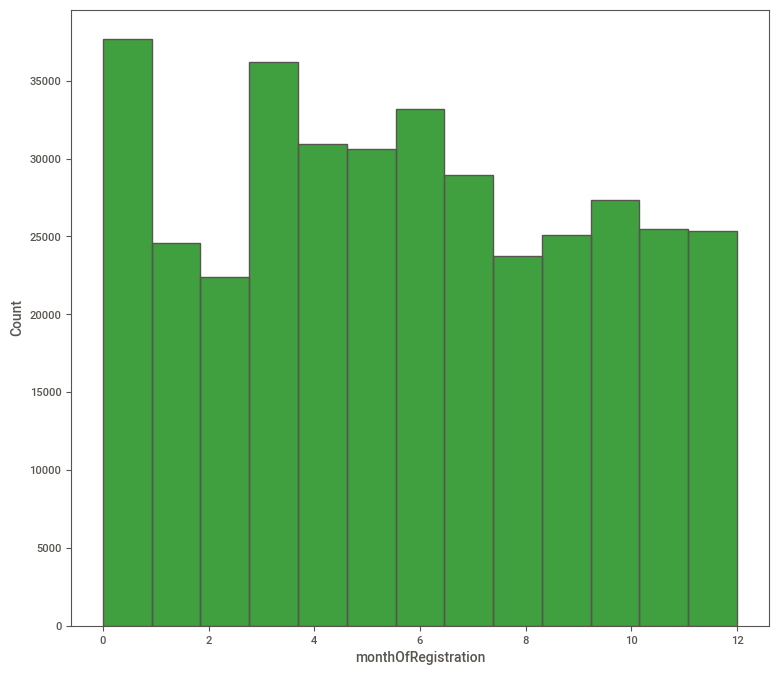

In [106]:
plt.figure(figsize=(9, 8))
sns.histplot(df['monthOfRegistration'], color='g', bins=13)
plt.show()

In [107]:
df_teste = df.copy()
# Filtrar os valores diferentes de 0 e calcular a moda
month_mode = df[df['monthOfRegistration'] != 0]['monthOfRegistration'].mode()[0]

df_teste['monthOfRegistration'] = df_teste['monthOfRegistration'].replace(0, month_mode)

# Verificando o resultado
print(df_teste['monthOfRegistration'].value_counts())

monthOfRegistration
3     73845
6     33166
4     30918
5     30631
7     28956
10    27337
11    25489
12    25380
9     25074
1     24560
8     23765
2     22403
Name: count, dtype: int64


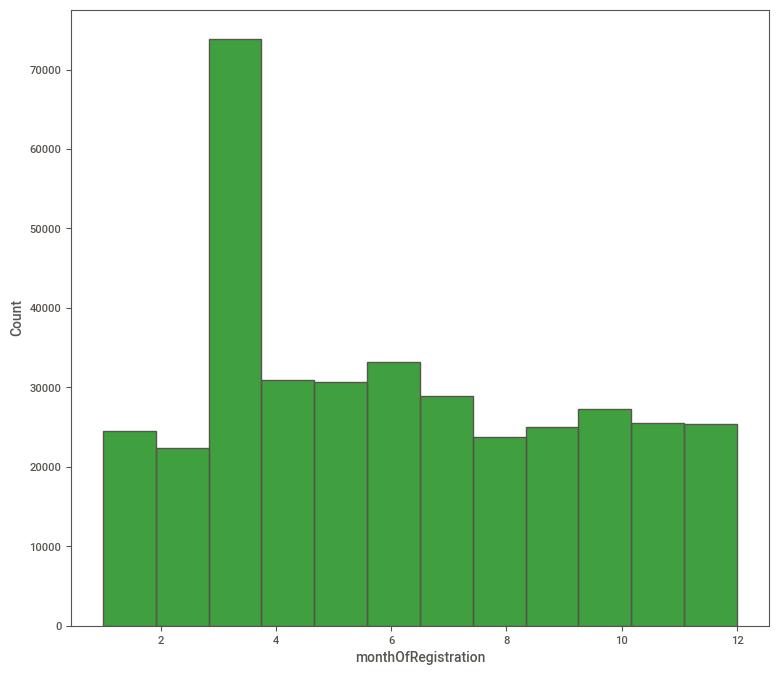

In [108]:
plt.figure(figsize=(9, 8))
sns.histplot(df_teste['monthOfRegistration'], color='g', bins=12)
plt.show()

* Essa transformação desbalanceou a distribuição dos nosso dados? Em minha opinião, Sim. Então droparei essas linhas. São 37k linhas, o que é aproximadamente 10% do nosso conjunto de dados. É bastante coisa, mas não correrei o risco de criar um víes em meu modelo. Tendo em vista que foi possível tratar todas as outras anomalias sem a necessidade de dropar linhas, me darei ao luxo de dropar estas

In [109]:
# Dropando as linhas que contém o mês 0
df = df[df['monthOfRegistration'] != 0]

In [110]:
# Verificando quantas variações nós temos
df.fuelType.value_counts()

,count
fuelType,
benzin,225022
diesel,102794
lpg,4962
cng,538
hybrid,270
andere,167
elektro,96


In [111]:
# Encontrar as 3 categorias mais comuns
top_3_fuel_types = df['fuelType'].value_counts().nlargest(2).index

# Substituir todas as outras categorias por "outros"
df.loc[~df['fuelType'].isin(top_3_fuel_types), 'fuelType'] = 'outros'

# Verificando o resultado
print(df['fuelType'].value_counts())

fuelType
benzin    225022
diesel    102794
outros      6033
Name: count, dtype: int64


In [112]:
# Converter a coluna 'dateCreated' para datetime
df['dateCreated'] = pd.to_datetime(df['dateCreated'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333849 entries, 1 to 371527
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   seller               333849 non-null  object        
 1   offerType            333849 non-null  object        
 2   price                333849 non-null  float64       
 3   abtest               333849 non-null  object        
 4   vehicleType          333849 non-null  object        
 5   yearOfRegistration   333849 non-null  int64         
 6   gearbox              333849 non-null  object        
 7   powerPS              333849 non-null  int64         
 8   model                333849 non-null  object        
 9   kilometer            333849 non-null  int64         
 10  monthOfRegistration  333849 non-null  int64         
 11  fuelType             333849 non-null  object        
 12  brand                333849 non-null  object        
 13  notRepairedDamage  

<ipython-input-112-2c8e90761b17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dateCreated'] = pd.to_datetime(df['dateCreated'], errors='coerce')


In [113]:

# Criar a coluna 'ano' a partir da coluna 'dateCreated'
df.loc[:, 'ano'] = df['dateCreated'].dt.year

In [114]:
# Remover as colunas 'dateCreated' e 'lastSeen'
df = df.loc[:, df.columns.difference(['dateCreated', 'lastSeen'])]

* Nosso foco é prever o valor do carro em si e não se o carro foi vendido ou não. Por isso, não faz sentido utilizarmos as colunas de data de criação do anúncio / última visualização, por isso, vou dropar essas colunas

In [115]:
# Pegando o maior valor da coluna "ano", que criamos na célula anterior
df['intervaloAnos'] = (df['ano'].max() - df['yearOfRegistration'])

In [116]:
df.head()

,abtest,ano,brand,fuelType,gearbox,kilometer,model,monthOfRegistration,notRepairedDamage,offerType,powerPS,price,seller,vehicleType,yearOfRegistration,intervaloAnos
1,test,2016,audi,diesel,manuell,125000,golf,5,ja,Angebot,190,18300.0,privat,outros,2011,5
2,test,2016,jeep,diesel,automatik,125000,outros,8,nein,Angebot,163,9800.0,privat,outros,2004,12
3,test,2016,volkswagen,benzin,manuell,150000,golf,6,nein,Angebot,75,1500.0,privat,kleinwagen,2001,15
4,test,2016,skoda,diesel,manuell,90000,outros,7,nein,Angebot,69,3600.0,privat,kleinwagen,2008,8
5,test,2016,bmw,benzin,manuell,150000,3er,10,ja,Angebot,102,650.0,privat,limousine,1995,21


In [117]:
df = df.loc[:, df.columns.difference(['ano'])]

* O que eu fiz nessas 3 células anteriores: Criei uma coluna chamada "ano". Essa coluna, é o tempo atual do conjunto de dados. Pegando o maior valor da data de criação dos anúncios, consigo saber o tempo atual em que o conjunto de dados foi criado. Com isso, basta que eu subtraia esse valor pela data de registro do carro, assim consigo ter uma estimativa da "idade" daquele carro. Isso pode nos trazer informações valiosas sobre o preço

### Normalização das variáveis numéricas

In [118]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols[num_cols != 'price']

# Inicializar o MinMaxScaler
scaler = MinMaxScaler()

# Aplicar a normalização
df[num_cols] = scaler.fit_transform(df[num_cols])

* Ao normalizar, nós diminuímos o intervalo dos valores nas variáveis numéricas, o que facilita a aprendizagem para o nosso modelo

### Tratamento das variáveis categóricas

In [119]:
# Selecionar colunas de tipo objeto
texto_cols = df.select_dtypes(include=['object']).columns

# Aplicar One-Hot Encoding
df = pd.get_dummies(df, columns=texto_cols, drop_first=True)
df.head()

,intervaloAnos,kilometer,monthOfRegistration,powerPS,price,yearOfRegistration,abtest_test,brand_audi,brand_bmw,brand_chevrolet,...,gearbox_manuell,model_andere,model_golf,model_outros,notRepairedDamage_nein,offerType_Gesuch,seller_privat,vehicleType_kombi,vehicleType_limousine,vehicleType_outros
1,0.887654,0.827586,0.363636,0.00950,18300.0,0.112346,True,True,False,False,...,True,False,True,False,False,False,True,False,False,True
2,0.888432,0.827586,0.636364,0.00815,9800.0,0.111568,True,False,False,False,...,False,False,False,True,True,False,True,False,False,True
3,0.888765,1.000000,0.454545,0.00375,1500.0,0.111235,True,False,False,False,...,True,False,True,False,True,False,True,False,False,False
4,0.887988,0.586207,0.545455,0.00345,3600.0,0.112012,True,False,False,False,...,True,False,False,True,True,False,True,False,False,False
5,0.889432,1.000000,0.818182,0.00510,650.0,0.110568,True,False,True,False,...,True,False,False,False,False,False,True,False,True,False


* Ao tratar as variáveis categóricas, permitimos que nosso modelo compreenda esses dados, pois os modelos de Machine Learning compreendem apenas números, então precisamos que nossos dados estejam em formatos numéricos para a aprendizagem do nosso modelo

### Conjunto de treino e teste

In [120]:
X = df.iloc[:, :]
X.drop('price', axis=1, inplace=True)
y = df['price']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# EDA

## Não farei um EDA tão aprofundado, pois junto ao pre processamento, tivemos bons insights sobre o nosso conjunto de dados

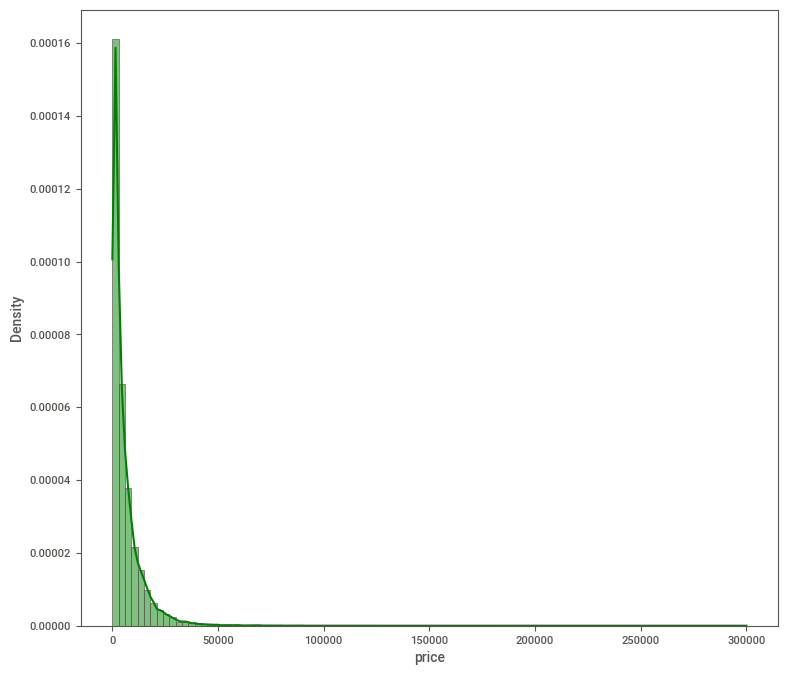

In [122]:
plt.figure(figsize=(9, 8))
sns.histplot(df['price'], color='g', bins=100, kde=True, stat="density")
plt.show()

* A padronização diminuiu drasticamente a distribuição que tínhamos nos dados

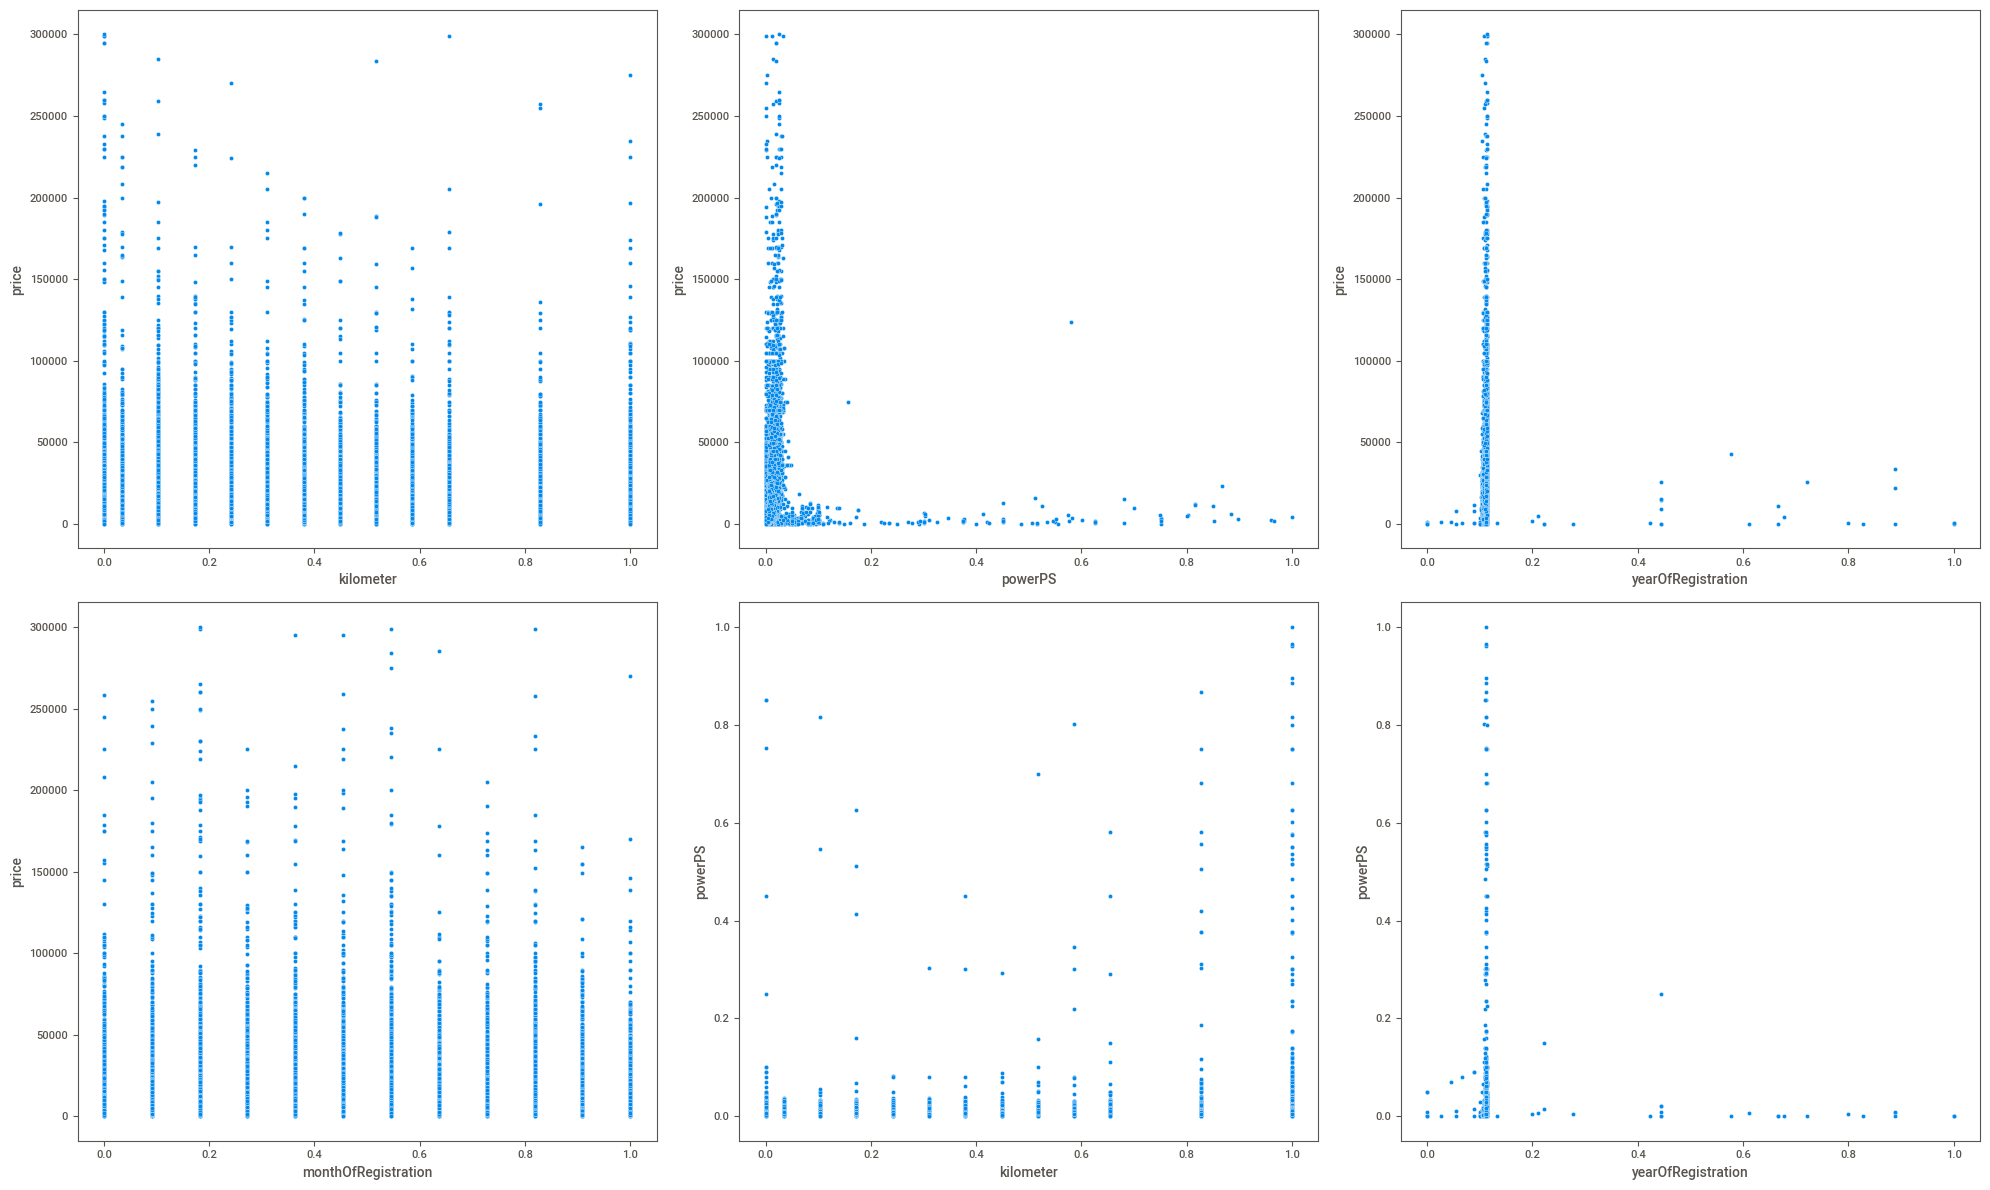

In [123]:
# Criar uma matriz 3x3 de subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # Ajustando para 3x3

# Plotar o primeiro gráfico no eixo [0, 0]
sns.scatterplot(x='kilometer', y='price', data=df, ax=axes[0, 0])

# Exemplo de mais gráficos, adicione mais plots nos outros eixos
sns.scatterplot(x='powerPS', y='price', data=df, ax=axes[0, 1])
sns.scatterplot(x='yearOfRegistration', y='price', data=df, ax=axes[0, 2])
sns.scatterplot(x='monthOfRegistration', y='price', data=df, ax=axes[1, 0])
sns.scatterplot(x='kilometer', y='powerPS', data=df, ax=axes[1, 1])
sns.scatterplot(x='yearOfRegistration', y='powerPS', data=df, ax=axes[1, 2])

# Deixando as células [2, 0], [2, 1], e [2, 2] livres para mais gráficos

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

* Nossos dados contém muitos outliers e não possuímos uma distribuição normal. Por isso, mesmo fazendo uma padronização nos dados, ainda temos outliers. Não irei tratá-los, pois nosso modelo de árvore não é tão sensível à esses tipos de outliers, então não será um problema para nós

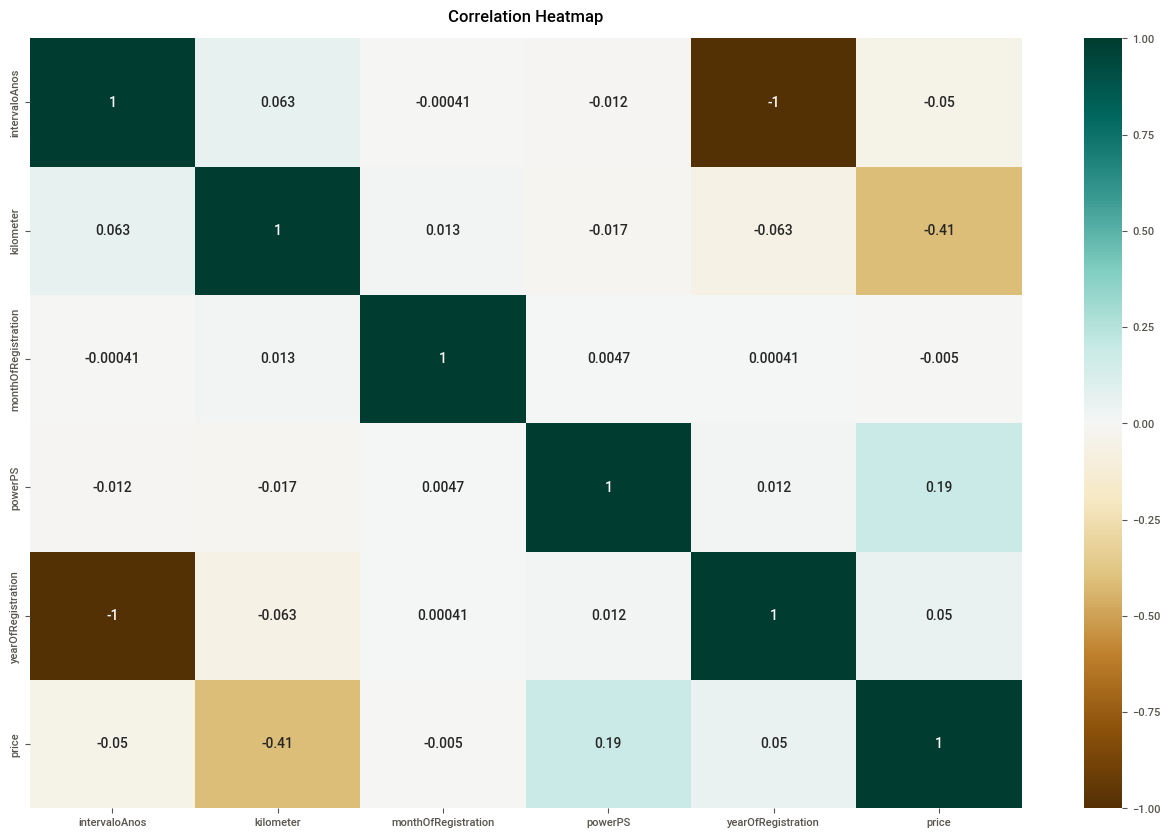

In [124]:
# Adicionar a coluna 'price' de volta à lista
num_cols = num_cols.append(pd.Index(['price']))
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df[num_cols].corr(), cmap='BrBG', annot=True)
heatmap.set_title('Correlation Heatmap', pad=12);

* Não vemos muitas correlações das variáveis numéricas com a nossa variável alvo "price". Mas powerPS apresentou a melhor correlação

# Treinamento do nosso modelo

In [125]:
# Inicializando o RandomForestRegressor com hiperparâmetros definidos manualmente
random_forest = RandomForestRegressor(
    n_estimators=10,      # Número de árvores na floresta
    max_depth=5,          # Profundidade máxima da árvore
    min_samples_split=4,  # Número mínimo de amostras para dividir um nó
    min_samples_leaf=2,   # Número mínimo de amostras por folha
    max_features='sqrt',  # Número de características a serem consideradas para encontrar a melhor divisão
    bootstrap=True        # Utiliza amostras com reposição
)

# Ajustar o modelo com os dados de treinamento
random_forest.fit(X_train, y_train)

# Fazer previsões com os dados de teste
y_pred = random_forest.predict(X_test)

# Avaliar o desempenho do modelo utilizando MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 2864.922498237816


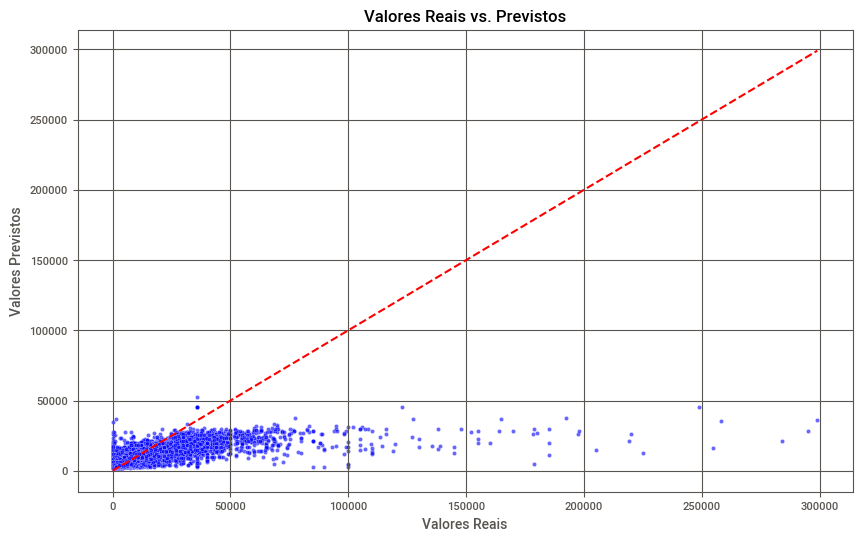

In [126]:
# Plotando os valores reais vs valores previstos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6)

# Adicionando a linha de identidade (valores perfeitos)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.title('Valores Reais vs. Previstos')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.grid(True)
plt.show()

# Conclusão

## Nosso conjunto de dados não apresentava uma distribuição normal e estava bastante disperso. Ao utilizar um modelo de Random Forest, ele foi impactado por isso. Acredito que o XGBoost ou o LightGBM seriam mais apropriados para esse conjunto de dados, pois, além de oferecerem melhores desempenhos, também permitem a utilização de GPU durante os treinamentos, proporcionando maiores opções de testes nos hiperparâmetros. Além disso, há a possibilidade de que, se eu tivesse tratado outliers nas minhas variáveis independentes, e não somente na variável dependente, possivelmente o modelo teria uma melhor performance